In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# 1. Introduction

The objective of this project is to build a machine learning model to identify if a tweet is about a real disaster or not. This is a supervised text classification task and we will go through various approaches from basic to advanced to see and compare the results. 

The task involves Natural Language Processing (NLP) which enables machine to understand human language and sentiments. However there are going to some key challenges due to small size (tweets) and the noise (tags, urls, informal slangs) involved.

Lets import all the libraries here

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix


Lets load the data

In [15]:
# Load datasets
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print("Training Data:")
print(train_df.info())
print(train_df)
print("Testing Data:")
print(test_df.info())
print(test_df)


Training Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ro

# 2. Exploratory Data Analysis (EDA)

The testing data contains 7613 records with the target record holding the output value. The testing data contain 3263 records.

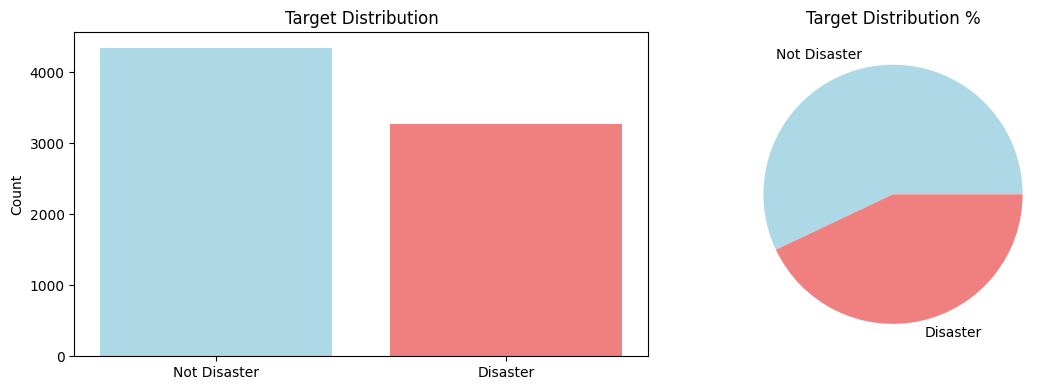

Target distribution:
Not disaster (0): 4342 (57.0%)
Disaster (1): 3271 (43.0%)


In [5]:
# Target distribution visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
target_counts = train_df['target'].value_counts()
plt.bar(['Not Disaster', 'Disaster'], target_counts.values, color=['lightblue', 'lightcoral'])
plt.title('Target Distribution')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(target_counts.values, labels=['Not Disaster', 'Disaster'], colors=['lightblue', 'lightcoral'])
plt.title('Target Distribution %')

plt.tight_layout()
plt.show()

print("Target distribution:")
print(f"Not disaster (0): {target_counts[0]} ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"Disaster (1): {target_counts[1]} ({target_counts[1]/len(train_df)*100:.1f}%)")

Now lets do some text length analysis to see if there's any correlation between a real on the moment disaster tweet length vs the other ones.

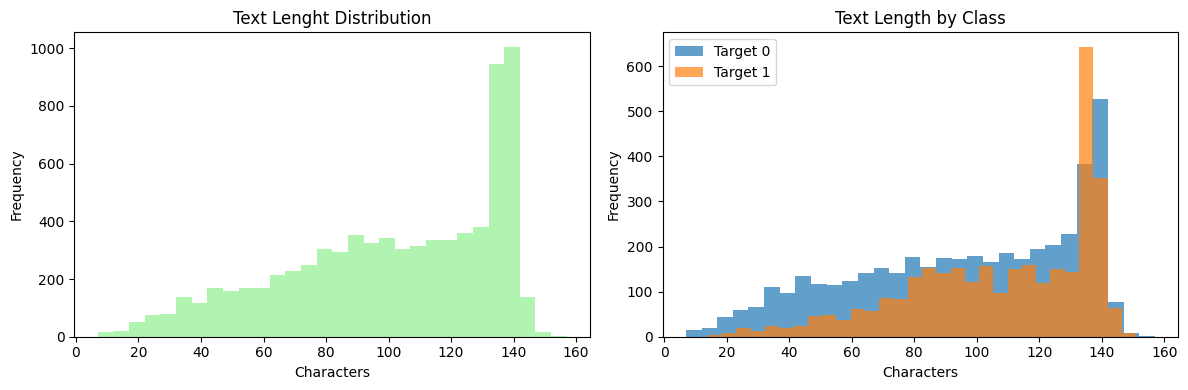

In [6]:
# Add a column of length
train_df['text_length'] = train_df['text'].str.len()

# Text lenght visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
target_counts = train_df['target'].value_counts()
plt.hist(train_df['text_length'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Text Lenght Distribution')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
for target in [0, 1]:
    subset = train_df[train_df['target'] == target]['text_length']
    plt.hist(subset, bins=30, alpha=0.7, label=f'Target {target}')
plt.title('Text Length by Class')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

We see almost similar textual length distribution between the real and the other tweets. Lets confirm with a box plot as well.

Text(0, 0.5, 'Characters')

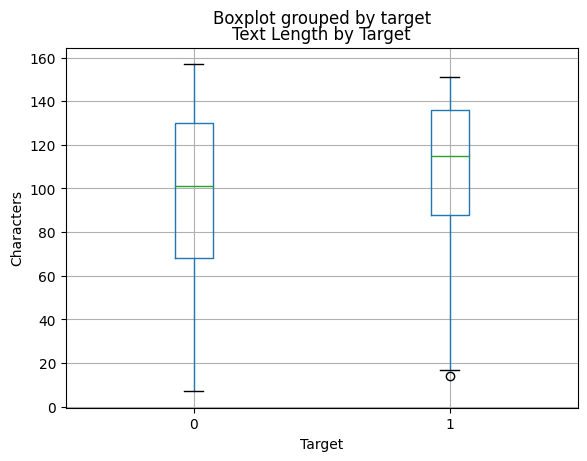

In [7]:
train_df.boxplot(column='text_length', by='target', ax=plt.gca())
plt.title('Text Length by Target')
plt.xlabel('Target')
plt.ylabel('Characters')

Yes, we can see the average and the mix and max are not much different between these two categories of texts.

Now lets check if there are any missing values

In [16]:
# Missing values if any will be listed here
for col in train_df.columns:
    missing_count = train_df[col].isnull().sum()
    if missing_count > 0:
        print(f"Column - {col}: Missing {missing_count} i.e., {missing_count/len(train_df)*100:.1f}% of entries!")

Column - keyword: Missing 61 i.e., 0.8% of entries!
Column - location: Missing 2533 i.e., 33.3% of entries!


Now we proceed with filling the missing values. Also we shall normalize the tweets text.

In [17]:
# Lets fill the missing ones with NA
train_df['keyword'] = train_df['keyword'].fillna('NA')
train_df['location'] = train_df['location'].fillna('NA')

# Lets normalize the text
def normalize_text(text):
    # Remove URLs, mentions, hashtags for cleaner text
    text = re.sub(r'http\S+', '', text)  # To remove URLs
    text = re.sub(r'@\w+', '', text)     # To remove handle mentions
    text = re.sub(r'#(\w+)', r'\1', text)  # To keep content of hashtags
    return text.strip()

train_df['normalized_text'] = train_df['text'].apply(normalize_text)

# 3. Model Architecture

We shall take a step by step approach from basic Supervised Learning Logistic Regression model to advanced Deep Learning RNN, LSTN and GRU models. This should make us appreciate the progression of performance as had been dealt in this course.

First lets do the LR model and we shall refer it as the baseline model.

In [18]:
# Supervised Logistic Regression model
X = train_df['normalized_text']
y = train_df['target']

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

# Lets vectorize using Term Frequency-Inverse Document Frequency (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Logistic Regression training
lr_model = LogisticRegression(random_state=24)
lr_model.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred = lr_model.predict(X_val_tfidf)

print(f"Baseline Model")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred))

Baseline Model
Accuracy: 0.7806959947472094
F1 Score: 0.7188552188552189
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       869
           1       0.80      0.65      0.72       654

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523



Lets plot the confusion matrix of this baseline model

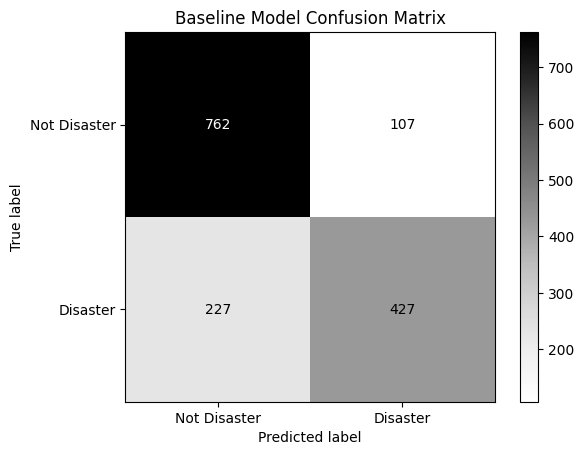

In [11]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=['Not Disaster', 'Disaster'], cmap='Greys')
plt.title('Baseline Model Confusion Matrix')
plt.show()

Now we move to Deep Learning models. Lets import the libraries first.

In [14]:
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

The build RNN model we need to tokenize the the text, create sequences and pad it. 

In [9]:
# Text tokenization for RNN models
words_size = 20000
max_length = 100

tokenizer = Tokenizer(num_words=words_size, lower=True)
tokenizer.fit_on_texts(X_train)

# Now convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Now pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

print(f"Training sequences shape: {X_train_pad.shape}")
print(f"Validation sequences shape: {X_val_pad.shape}")

Training sequences shape: (6090, 100)
Validation sequences shape: (1523, 100)


Now we proceed to build RNN model.

In [54]:
tf.random.set_seed(24)

rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=words_size, output_dim=128, input_length=max_length),
    #SimpleRNN(64, dropout=0.2, recurrent_dropout=0.1), 
    #Dense(32, activation='relu'),                       
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

# Use a lower learning rate for better convergence
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rnn_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
rnn_model.summary()
print("RNN Model built successfully")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

RNN Model built successfully


Time to train the model

In [55]:
#Training the model
rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    epochs=5,                                    
    batch_size=64,                              
    validation_data=(X_val_pad, y_val),          
    verbose=2
)

Epoch 1/5
96/96 - 47s - 494ms/step - accuracy: 0.6872 - loss: 0.5801 - val_accuracy: 0.7814 - val_loss: 0.4902
Epoch 2/5
96/96 - 41s - 424ms/step - accuracy: 0.8616 - loss: 0.3405 - val_accuracy: 0.7787 - val_loss: 0.5177
Epoch 3/5
96/96 - 40s - 420ms/step - accuracy: 0.9202 - loss: 0.2227 - val_accuracy: 0.7728 - val_loss: 0.6113
Epoch 4/5
96/96 - 40s - 421ms/step - accuracy: 0.9496 - loss: 0.1539 - val_accuracy: 0.7676 - val_loss: 0.6676
Epoch 5/5
96/96 - 40s - 420ms/step - accuracy: 0.9606 - loss: 0.1155 - val_accuracy: 0.7564 - val_loss: 0.7627


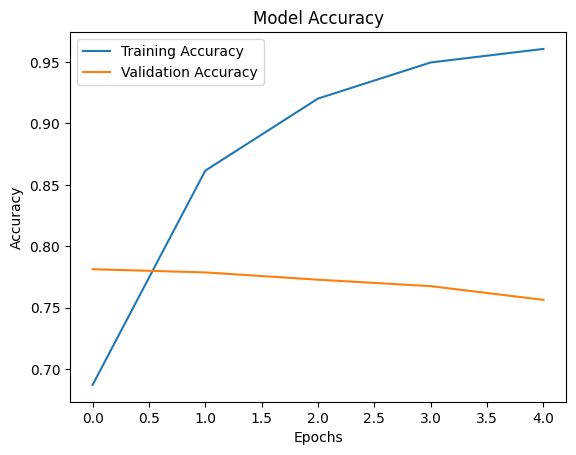

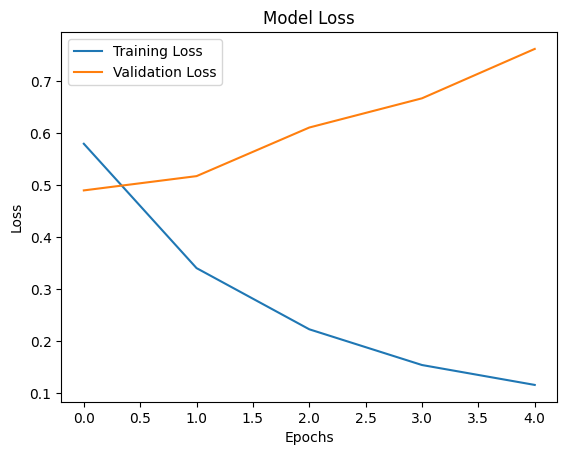

In [56]:
# Plot accuracy
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
# Evaluate the RNN model

y_pred_rnn = (rnn_model.predict(X_val_pad) > 0.5).astype(int).flatten()
rnn_accuracy = accuracy_score(y_val, y_pred_rnn)
rnn_f1 = f1_score(y_val, y_pred_rnn)

print(f"Vanilla RNN Results:")
print(f"Accuracy: {rnn_accuracy:.4f}")
print(f"F1-Score: {rnn_f1:.4f}")
print(f"Classification Report:")
print(classification_report(y_val, y_pred_rnn, target_names=['Non-disaster', 'Disaster']))

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step
Vanilla RNN Results:
Accuracy: 0.7564
F1-Score: 0.7010
Classification Report:
              precision    recall  f1-score   support

Non-disaster       0.77      0.83      0.79       869
    Disaster       0.74      0.67      0.70       654

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.75      1523



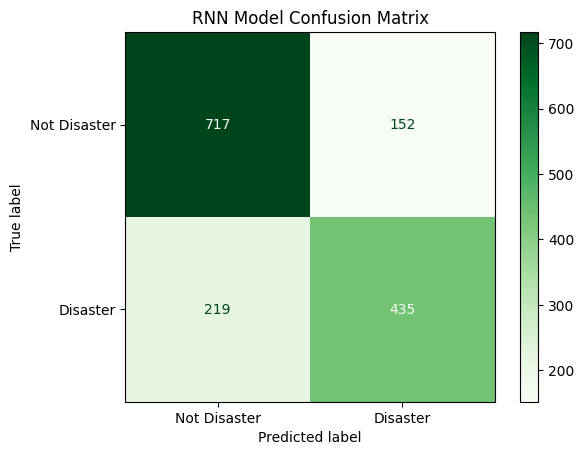

In [58]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_rnn, display_labels=['Not Disaster', 'Disaster'], cmap='Greens')
plt.title('RNN Model Confusion Matrix')
plt.show()

# 4. Results and Analysis

First lets try a different architecture. We shall make use of pretrained embeddings from Word2Vec (glove-twitter-100) and analyse its performance.

In [19]:
# Loading pretrained Word2Vec embeddings (glove-twitter-100) 
import gensim.downloader as api
wv = api.load("glove-twitter-100")  # 100-dim embeddings trained on Twitter

embedding_dim = 100

word_index = tokenizer.word_index
num_tokens = min(words_size, len(word_index)) + 1

# Build embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if i >= num_tokens:
        continue
    if word in wv:
        embedding_matrix[i] = wv[word]




In [21]:
# Build LSTM model
lstm_wv_model = Sequential([
    Embedding(
        input_dim=num_tokens,
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embedding_matrix],
        trainable=False  # freeze embeddings to prevent overfitting
    ),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])



In [22]:
lstm_wv_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

lstm_wv_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,395,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,200 (5.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,395,200 (5.32 MB)

In [23]:

# Train the model
lstm_wv_history = lstm_wv_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=32,
    verbose=2
)


Epoch 1/5
191/191 - 80s - 417ms/step - accuracy: 0.7540 - loss: 0.5196 - val_accuracy: 0.7879 - val_loss: 0.4802
Epoch 2/5
191/191 - 70s - 368ms/step - accuracy: 0.8020 - loss: 0.4512 - val_accuracy: 0.7879 - val_loss: 0.4730
Epoch 3/5
191/191 - 70s - 368ms/step - accuracy: 0.8102 - loss: 0.4298 - val_accuracy: 0.7938 - val_loss: 0.4746
Epoch 4/5
191/191 - 70s - 368ms/step - accuracy: 0.8182 - loss: 0.4187 - val_accuracy: 0.7833 - val_loss: 0.4858
Epoch 5/5
191/191 - 71s - 370ms/step - accuracy: 0.8205 - loss: 0.4091 - val_accuracy: 0.7971 - val_loss: 0.4798


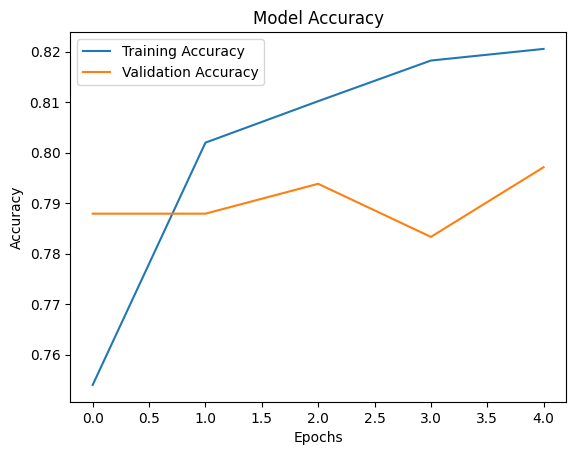

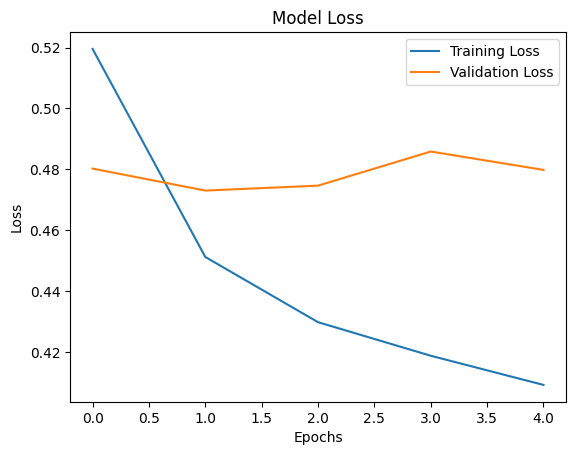

In [25]:
# Plot accuracy
plt.plot(lstm_wv_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_wv_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(lstm_wv_history.history['loss'], label='Training Loss')
plt.plot(lstm_wv_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Lets run the predictions

In [26]:
# Evaluate the W2V LSTM model

y_pred_lstm_wv = (lstm_wv_model.predict(X_val_pad) > 0.5).astype(int).flatten()
lstm_wv_accuracy = accuracy_score(y_val, y_pred_lstm_wv)
lstm_wv_f1 = f1_score(y_val, y_pred_lstm_wv)

print(f"Vanilla RNN Results:")
print(f"Accuracy: {lstm_wv_accuracy:.4f}")
print(f"F1-Score: {lstm_wv_f1:.4f}")
print(f"Classification Report:")
print(classification_report(y_val, y_pred_lstm_wv, target_names=['Non-disaster', 'Disaster']))

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step
Vanilla RNN Results:
Accuracy: 0.7971
F1-Score: 0.7569
Classification Report:
              precision    recall  f1-score   support

Non-disaster       0.81      0.84      0.83       869
    Disaster       0.78      0.74      0.76       654

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



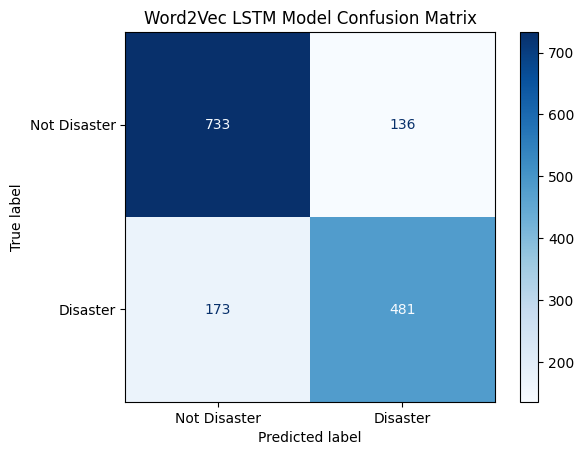

In [27]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_lstm_wv, display_labels=['Not Disaster', 'Disaster'], cmap='Blues')
plt.title('Word2Vec LSTM Model Confusion Matrix')
plt.show()

The LSTM model using pretrained Word2Vec (glove-twitter-100) embeddings achieved slightly higher validation accuracy than the Logistic Regression baseline. We have seen results like:
Linear Regression - 78% Accuracy
Simple RNN - 75% Accuracy
Word2Vec - 79% Accuracy

This confirms that the usage of pretrained embeddings has provided additional semantic information that benefits sequence models, even on small datasets.


# 5. Conclusion

In this project, we went through evaluating the classical as well as deep learning methods. We observed the Supervised Linear Regression model with TF-IDF worked out well for the small dataset we have here. The basic vanilla RNN couldnt do better for the same reason of smaller dataset. And pretrained models had the benefit even over this smaller dataset.

The main takeaways are the strength of classic models, the value of pretrained models and the resource considerations within Kaggle environment which took up considerable time to run and rerun the models.

Future work could include testing the other pretrained embeddings like GloVe etc which are resource intensive and though attempted I couldnt get it running. Also each parameter at each layer of the models could be tuned, which though is expensive, could result in the best possible performance going well beyond 80% of accuracy. There is scope for further research and development here to reach near 100% human like accuracy.

We conclude this project by creating the submission file to Kaggle.

In [30]:
test_texts = test_df['text'].values
test_sequences = tokenizer.texts_to_sequences(test_texts)
X_test_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
test_pred_prob = lstm_wv_model.predict(X_test_pad)
test_pred = (test_pred_prob > 0.5).astype(int).flatten()
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_pred
})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved!")
#submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step
Submission file saved!


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
